# Tweets sentiment analysis with RNN

Multi input architecture:
1) keyword embedding
2) tweet cleaned text embedding + RNN + dense layer


In [199]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
FILE_ID='D-RNN-v2'

In [200]:
df = pd.read_csv('./train_enriched.csv')
X = df['clean_text'].fillna('').to_numpy()
Y = df['target'].to_numpy()
X2 = df['keyword'].fillna('').to_numpy()

# df_train = pd.read_csv('./train-dataset.csv')
# df_dev = pd.read_csv('./dev-dataset.csv')

X_train, X_dev, Y_train, Y_dev, X2_train, X2_dev = train_test_split(X, Y, X2, test_size=0.1, shuffle=True)
# X_train = df_train['text'].to_numpy()
# Y_train = df_train['target'].to_numpy()
# X_dev = df_dev['text'].to_numpy()
# Y_dev = df_dev['target'].to_numpy()

print(X_train.shape, X2_train.shape, Y_train.shape, X_dev.shape, X2_dev.shape, Y_dev.shape)
X_train[:3]

(6851,) (6851,) (6851,) (762,) (762,) (762,)


array(['rip the world its burning',
       'strengthening partnerships afterhaiyan haiyan yolandaph philippines livelihood disasterrecovery disaster',
       'dudes will thoroughly express how stupid black ppl r for burning buildings in response to brutality but nvr mention them being mistreated'],
      dtype=object)

In [201]:
VOCABULARY_SIZE = 10000
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 1024
LSTM_HIDDEN_STATES = 8
DENSE_HIDDEN_STATES = 32

In [202]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCABULARY_SIZE, output_sequence_length=MAX_SEQ_LEN)
encoder.adapt(X_train)

keyword_encoder = tf.keras.layers.TextVectorization(max_tokens=1000, output_sequence_length=2)
keyword_encoder.adapt(X2_train)

In [203]:
vocabulary = encoder.get_vocabulary()
print('Vocabulary size:', VOCABULARY_SIZE)

Vocabulary size: 10000


In [204]:
example = X_train[11]
encoded = encoder(example)
print('Example:', example)
words = [vocabulary[e] for e in encoded]
decoded = ' '.join(words)
print('Decoded:', decoded)


Example: top insurer blasts lack of australian govt action on disaster mitigation via
Decoded: top insurer blasts lack of australian govt action on disaster mitigation via                                                                                        


In [205]:
def get_1_RNN_model(X, X2, Y):    
    input_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    encoded_layer = encoder(input_1)
    embedded_1 = tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE+1, output_dim=EMBEDDING_DIM, mask_zero=True)(encoded_layer)
    print('embedded_1',embedded_1.shape)
    bidirectional_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_HIDDEN_STATES))(embedded_1)
    dropout_1 = tf.keras.layers.Dropout(0.5)(bidirectional_1)

    keyword_vocabulary_size = len(keyword_encoder.get_vocabulary())
    print('keyword_vocabulary_size',keyword_vocabulary_size)
    input_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    encoded_layer_2 = keyword_encoder(input_2)
    embedded_2 = tf.keras.layers.Embedding(input_dim=keyword_vocabulary_size+1, output_dim=16, mask_zero=True)(encoded_layer_2)
    print('embedded_2', embedded_2.shape)
    flat_embedded_2 = tf.keras.layers.Flatten()(embedded_2)

    print('dropout_1', dropout_1.shape)
    print('flat_embedded_2', flat_embedded_2.shape)
    concat = tf.keras.layers.Concatenate()([dropout_1, flat_embedded_2])
    print('concat', concat.shape)
    dense_1 = tf.keras.layers.Dense(DENSE_HIDDEN_STATES, activation='relu')(concat)
    dropout_2 = tf.keras.layers.Dropout(0.5)(dense_1)
    dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)
    return tf.keras.Model(inputs=[input_1, input_2], outputs=[dense_2])


model = get_1_RNN_model(X_train, X2_train, Y_train)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


embedded_1 (None, 100, 1024)
keyword_vocabulary_size 223
embedded_2 (None, 2, 16)
dropout_1 (None, 16)
flat_embedded_2 (None, 32)
concat (None, 48)


In [206]:
print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_22 (TextVec  (None, 100)         0           ['input_68[0][0]']               
 torization)                                                                                      
                                                                                                  
 input_69 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_59 (Embedding)       (None, 100, 1024)    10241024    ['text_vectorization_22[0]

In [207]:
checkpoint_path = f"{FILE_ID}-best_model"  # Path where the model will be saved
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, 
                                                mode='min', save_weights_only=True)

model.fit([X_train, X2_train], Y_train, validation_data=((X_dev, X2_dev), Y_dev), epochs=3, callbacks=[checkpoint])

Epoch 1/3


2024-05-01 22:07:37.521292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-01 22:07:39.102864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


215/215 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.7233
Epoch 1: val_loss improved from inf to 0.45314, saving model to D-RNN-v2-best_model
215/215 [==============================] - 29s 118ms/step - loss: 0.5632 - accuracy: 0.7233 - val_loss: 0.4531 - val_accuracy: 0.7940
Epoch 2/3
215/215 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8647
Epoch 2: val_loss did not improve from 0.45314
215/215 [==============================] - 23s 107ms/step - loss: 0.3647 - accuracy: 0.8647 - val_loss: 0.4595 - val_accuracy: 0.7966
Epoch 3/3
215/215 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9180
Epoch 3: val_loss did not improve from 0.45314
215/215 [==============================] - 24s 111ms/step - loss: 0.2355 - accuracy: 0.9180 - val_loss: 0.5647 - val_accuracy: 0.7874


In [208]:
model.load_weights(checkpoint_path)
Y_dev_pred = model.predict([X_dev, X2_dev])

24/24 [==============================] - 2s 13ms/step


In [209]:
Y_dev_pred = (Y_dev_pred > .5).astype(np.int8)


In [210]:
X_dev[0]

'ok severe thunderstorm warning issued august at 829pm cdt until august at 915pm cdt by nws okwx'

In [211]:
result = pd.DataFrame(X_dev)
result['y'] = Y_dev
result['yp'] = Y_dev_pred

f_encode = lambda it: encoder(it)
f_embedd = lambda it: ' '.join([vocabulary[e] for e in it])

encoded = f_encode(X_dev)
decoded = np.apply_along_axis(f_embedd, axis=1, arr=encoded)
print(decoded[1])
print(X_dev[1])

result['decoded'] = decoded
result

[UNK] [UNK] [UNK] [UNK] in [UNK] several persons were [UNK] injured on wednesday when men o rt                                                                                   
ogun smugglers engage customs in shootout several persons were allegedly injured on wednesday when men o rt


,0,y,yp,decoded
0,ok severe thunderstorm warning issued august at 829pm cdt until august at 915pm cdt by nws okwx,1,1,ok severe thunderstorm warning issued august at [UNK] cdt until august at [UNK] cdt by nws okwx
1,ogun smugglers engage customs in shootout several persons were allegedly injured on wednesday when men o rt,1,1,[UNK] [UNK] [UNK] [UNK] in [UNK] several persons were [UNK] injured on wednesday when men o rt
2,sb57 new deepwater horizon oil spill distribution of funds from bp settlement road and bridge projects in bal,1,1,[UNK] new [UNK] [UNK] oil spill [UNK] of funds from bp settlement road and bridge projects in [UNK]
3,heat wave is relentless 91f feels like humidity relentless drought too now dominicana i know is worse in other places,1,1,heat wave is [UNK] [UNK] feels like humidity [UNK] drought too now [UNK] i know is worse in other places
4,i should bloody hope so she said folding her arms sitting back in her chair,0,0,i should bloody hope so she said [UNK] her arms sitting back in her [UNK]
...,...,...,...,...
757,it wouldnt turn into a sandstorm if riot gave a good answer instead they gave dumb excuses at least new client is there,0,0,it wouldnt turn into a sandstorm if riot gave a good answer instead they gave [UNK] [UNK] at least new client is there
758,marquei como visto game of thrones 3x5 kissed by fire bancodeseries,0,0,marquei [UNK] visto game of thrones [UNK] [UNK] by fire [UNK]
759,crash test trailer paul scheer amp rob huebels comedy special recorded on a,0,0,crash test trailer paul [UNK] amp rob [UNK] comedy special recorded on a
760,italy three dead after landslide in the italian alps via,1,1,italy three dead after landslide in the italian alps via


In [212]:
pd.set_option('display.max_colwidth', None)
result.query('y != yp').sample(n=10)

,0,y,yp,decoded
297,ignition knock detonation sensorsenso standard ks94,1,0,ignition knock detonation sensorsenso standard [UNK]
682,i love gal deco to death even if its a bit trickier to be great with glad more weapons are getting splash wall,1,0,i love [UNK] [UNK] to death even if its a bit [UNK] to be great with glad more weapons are getting [UNK] wall
404,cascada evacuate the dancefloor official video via,0,1,[UNK] evacuate the [UNK] official video via
693,i was peacefully sitting in my room and i heard this loud bang of something falling,1,0,i was peacefully sitting in my room and i heard this loud bang of something falling
650,truth news bbc cnn islam truth god isis terrorism quran lies,0,1,truth news bbc cnn islam truth god isis terrorism quran lies
247,even staying up all night to he barrier for tp and then having to run through a dust storm and almost passing out,1,0,even [UNK] up all night to he [UNK] for [UNK] and then having to run through a dust storm and almost passing out
730,the fake of nanking massacre4 eyewitnesses english obama clinton bush gop abc cbs bbc cnn wsj wpo,1,0,the fake of [UNK] [UNK] [UNK] english obama clinton bush gop abc [UNK] bbc cnn [UNK] [UNK]
231,dont get on i77 south huge wreck and airlift and maybe some deaths interstate is completely blocked,1,0,dont get on i77 south huge wreck and [UNK] and maybe some deaths [UNK] is completely blocked
550,so you have a new weapon that can cause unimaginable destruction,1,0,so you have a new weapon that can cause [UNK] destruction
551,you happen to conveniently forget about how you zionists revere and honour mass murderer baruch goldstein,1,0,you happen to [UNK] forget about how you [UNK] [UNK] and [UNK] mass murderer [UNK] [UNK]


Accuracy: 0.7939632545931758
Precision: 0.7993618749274858
Recall: 0.7741160972293047
F1 Score: 0.7804570554004877


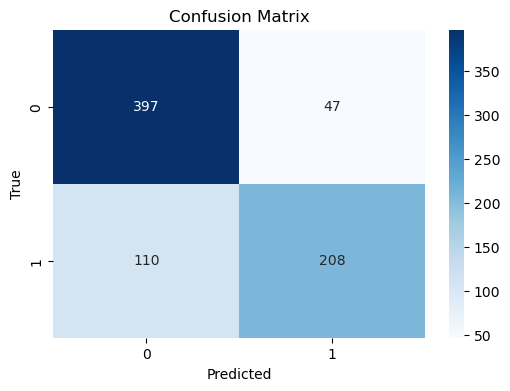

In [213]:
# Compute the confusion matrix
cm = confusion_matrix(Y_dev, Y_dev_pred)

# Compute other metrics
accuracy = accuracy_score(Y_dev, Y_dev_pred)
precision = precision_score(Y_dev, Y_dev_pred, average='macro')
recall = recall_score(Y_dev, Y_dev_pred, average='macro')
f1 = f1_score(Y_dev, Y_dev_pred, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [214]:
def generate_submission(model):
    df_test = pd.read_csv('./test_enriched.csv', index_col='id')
    df_test.fillna({'clean_text': '', 'keyword': '', 'location': '', 'country': '', 'state': '', 'city': '', 'url_domains': ''}, inplace=True)
    X_test = df_test['clean_text'].to_numpy()

    Y_test_predict = model(X_test)
    Y_test_predict = tf.cast(Y_test_predict > .5, tf.int32)

    df_example = pd.read_csv('./sample_submission.csv')
    df_example['target'] = Y_test_predict

    df_example.to_csv(f'./{FILE_ID}-submission.csv', index=False)


In [215]:
# generate_submission(model)